# Base-line predictor

Predicts the next value is equal to the previous

In [1]:
# from __future__ import absolute_import
# from __future__ import division
# from __future__ import print_function
import keras
# little path hack to get robojam from one directory up in the filesystem.
from context import * # imports robojam
# import robojam # alternatively do this.
import h5py
import numpy as np
import random
import time
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

input_colour = 'darkblue'
gen_colour = 'firebrick'
plt.style.use('seaborn-talk')

Using TensorFlow backend.


In [2]:
def perf_df_to_array(perf_df):
    """Converts a dataframe of a performance into array a,b,dt format."""
    perf_df['dt'] = perf_df.time.diff()
    perf_df.dt = perf_df.dt.fillna(0.0)
    # Clean performance data
    # Tiny Performance bounds defined to be in [[0,1],[0,1]], edit to fix this.
    perf_df.set_value(perf_df[perf_df.dt > 5].index, 'dt', 5.0)
    perf_df.set_value(perf_df[perf_df.dt < 0].index, 'dt', 0.0)
    perf_df.set_value(perf_df[perf_df.x > 1].index, 'x', 1.0)
    perf_df.set_value(perf_df[perf_df.x < 0].index, 'x', 0.0)
    perf_df.set_value(perf_df[perf_df.y > 1].index, 'y', 1.0)
    perf_df.set_value(perf_df[perf_df.y < 0].index, 'y', 0.0)
    return np.array(perf_df[['x', 'y', 'dt']])


def perf_array_to_df(perf_array):
    """Converts an array of a performance (a,b,dt format) into a dataframe."""
    perf_array = perf_array.T
    perf_df = pd.DataFrame({'x': perf_array[0], 'y': perf_array[1], 'dt': perf_array[2]})
    perf_df['time'] = perf_df.dt.cumsum()
    perf_df['z'] = 38.0
    # As a rule of thumb, could classify taps with dt>0.1 as taps, dt<0.1 as moving touches.
    perf_df['moving'] = 1
    perf_df.set_value(perf_df[perf_df.dt > 0.1].index, 'moving', 0)
    perf_df = perf_df.set_index(['time'])
    return perf_df[['x', 'y', 'z', 'moving']]


def random_touch():
    """Generate a random tiny performance touch."""
    return np.array([np.random.rand(), np.random.rand(), 0.01])


def constrain_touch(touch):
    """Constrain touch values from the MDRNN"""
    touch[0] = min(max(touch[0], 0.0), 1.0)  # x in [0,1]
    touch[1] = min(max(touch[1], 0.0), 1.0)  # y in [0,1]
    touch[2] = max(touch[2], 0.001)  # dt # define minimum time step
    return touch

def generate_random_tiny_performance(model, first_touch, time_limit=5.0, steps_limit=1000, temp=1.0, model_file=None):
    """Generates a tiny performance up to 5 seconds in length."""
    time = 0
    steps = 0
    previous_touch = first_touch
    performance = [previous_touch.reshape((3,))]
    while (steps < steps_limit and time < time_limit):
        previous_touch = model.predict(previous_touch.reshape(1,1,3))
        output_touch = previous_touch.reshape(3,)
        output_touch = constrain_touch(output_touch)
        performance.append(output_touch.reshape((3,)))
        steps += 1
        time += output_touch[2]
    return np.array(performance)


def condition_and_generate(model, perf, time_limit=5.0, steps_limit=1000, temp=1.0, model_file=None):
    """Conditions the network on an existing tiny performance, then generates a new one."""
    time = 0
    steps = 0
    # condition
    for touch in perf:
        previous_touch = model.predict(touch.reshape(1,1,3))
    output = [previous_touch.reshape((3,))]
    while (steps < steps_limit and time < time_limit):
        previous_touch = model.predict(previous_touch.reshape(1,1,3))
        output_touch = previous_touch.reshape(3,)
        output_touch = constrain_touch(output_touch)
        output.append(output_touch.reshape((3,)))
        steps += 1
        time += output_touch[2]
    net_output = np.array(output)
    return net_output

def divide_performance_into_swipes(perf_df):
    """Divides a performance into a sequence of swipe dataframes for plotting."""
    touch_starts = perf_df[perf_df.moving == 0].index
    performance_swipes = []
    remainder = perf_df
    for att in touch_starts:
        swipe = remainder.iloc[remainder.index < att]
        performance_swipes.append(swipe)
        remainder = remainder.iloc[remainder.index >= att]
    performance_swipes.append(remainder)
    return performance_swipes

def plot_2D(perf_df, name="foo", saving=False):
    """Plot a 2D representation of a performance 2D"""
    swipes = divide_performance_into_swipes(perf_df)
    plt.figure(figsize=(8, 8))
    for swipe in swipes:
        p = plt.plot(swipe.x, swipe.y, 'o-')
        plt.setp(p, color=gen_colour, linewidth=5.0)
    plt.ylim(1.0,0)
    plt.xlim(0,1.0)
    plt.xticks([])
    plt.yticks([])
    if saving:
        plt.savefig(name+".png", bbox_inches='tight')
        plt.close()
    else:
        plt.show()
        
def plot_double_2d(perf1, perf2, name="foo", saving=False):
    """Plot two performances in 2D"""
    plt.figure(figsize=(8, 8))
    swipes = divide_performance_into_swipes(perf1)
    for swipe in swipes:
        p = plt.plot(swipe.x, swipe.y, 'o-')
        plt.setp(p, color=input_colour, linewidth=5.0)
    swipes = divide_performance_into_swipes(perf2)
    for swipe in swipes:
        p = plt.plot(swipe.x, swipe.y, 'o-')
        plt.setp(p, color=gen_colour, linewidth=5.0)
    plt.ylim(1.0,0)
    plt.xlim(0,1.0)
    plt.xticks([])
    plt.yticks([])
    if saving:
        plt.savefig(name+".png", bbox_inches='tight')
        plt.close()
    else:
        plt.show()

In [3]:
# Base line model is not trained

# Training Hyperparameters:
SEQ_LEN = 1
BATCH_SIZE = 1
#HIDDEN_UNITS = 64
#EPOCHS = 100
#VAL_SPLIT=0.2

# These settings train for 2.1 epochs which is pretty good!
SEED = 2345  # 2345 seems to be good.

random.seed(SEED)
np.random.seed(SEED)
# tf.set_random_seed(5791)  # only works for current graph.

In [4]:
microjam_data_file_name = "../datasets/TinyPerformanceCorpus.h5"
metatone_data_file_name = "../datasets/MetatoneTinyPerformanceRecords.h5"

with h5py.File(microjam_data_file_name, 'r') as data_file:
    microjam_corpus = data_file['total_performances'][:]
with h5py.File(metatone_data_file_name, 'r') as data_file:
    metatone_corpus = data_file['total_performances'][:]

# sequence_loader = robojam.sample_data.SequenceDataLoader(num_steps=SEQ_LEN + 1, batch_size=BATCH_SIZE, corpus=microjam_corpus, overlap=False)
sequence_loader = robojam.sample_data.SequenceDataLoader(num_steps=SEQ_LEN + 1, batch_size=BATCH_SIZE, corpus=metatone_corpus, overlap=False)

X, y = sequence_loader.seq_to_singleton_format()
X = np.array(X)
y = np.array(y)
print("X:", X.shape, "y:", y.shape)

Total non-overlapping examples: 2149209
Done initialising loader.
X: (2149209, 1, 3) y: (2149209, 3)


In [5]:
def base_line_predictor(x):
    return x[-1]

In [6]:
decoder = keras.Sequential()
decoder.add(keras.layers.Lambda(base_line_predictor, batch_input_shape=(None,1,3)))#((lambda x: x),batch_input_shape=(1,1,3)))
decoder.compile(loss='mse', optimizer=keras.optimizers.Adam())
decoder.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lambda_1 (Lambda)            (1, 3)                    0         
Total params: 0
Trainable params: 0
Non-trainable params: 0
_________________________________________________________________


In [7]:
# Makes no sense to train the base-line preditor (no weights), instead we only evaluate.
#history = decoder.fit(X, y, epoch=10)

loss = decoder.evaluate(X,y)
print(loss)

2149209/2149209 [==============================] - 13s 6us/step
0.0628041825509


In [9]:
# Get training and test loss histories
#training_loss = history.history['loss']
#test_loss = history.history['val_loss']

# Create count of the number of epochs
#epoch_count = range(1, len(training_loss) + 1)

# # Visualize loss history
# plt.plot(epoch_count, training_loss, 'r--')
# plt.plot(epoch_count, test_loss, 'b-')
# plt.legend(['Training Loss', 'Test Loss'])
# plt.xlabel('Epoch')
# plt.ylabel('Loss')
# plt.show();

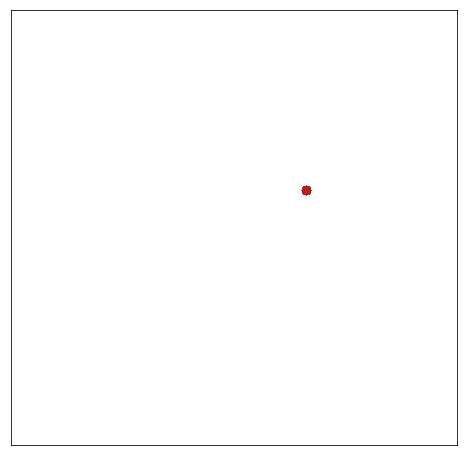

In [10]:
p = generate_random_tiny_performance(decoder, random_touch()) #, time_limit=60.0, steps_limit=10000) 
plot_2D(perf_array_to_df(p))

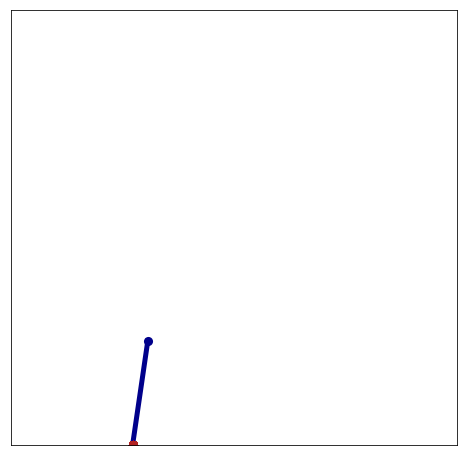

In [12]:
t = random.randint(0,len(sequence_loader.examples))

p = condition_and_generate(decoder,sequence_loader.examples[t])
plot_double_2d(perf_array_to_df(sequence_loader.examples[t]), perf_array_to_df(p))